In [1]:
import numpy as np
import dill
import torch.nn as nn
import torch
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import os
import Graphs
import networkx as nx
import torch.optim as optim
import random
import copy
import sys
import pandas as pd
from torch.nn import functional as F
from collections import defaultdict
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.optimizer import required
from torchinfo import summary
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.graphics.tsaplots import plot_acf
sns.set_theme(style="whitegrid")

In [2]:
bkdatafolder = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/BKDataCleaned/"

In [3]:
def createDictFloor(floor_idx,path):
    floorname = [f'Floor{idx}' for idx in floor_idx]
    fulldata = os.listdir(path)
    getdict = {}
    floors = [floor for name in floorname for floor in fulldata if name in floor]
    for name in floors:
        floor_zone = name.split(".")[0]
        getdict[floor_zone] = pd.read_csv(path+name, index_col=0, parse_dates=["Date"])
        getdict[floor_zone] = getdict[floor_zone].sort_index()
    return getdict

def Missing_values(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total,percent], axis=1, keys=['Total', 'Pourcentage'])
    print (missing_data[(percent>0)],'\n' )

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
        
def createDTFeat(date1, date2, datadict,featureX,resample_method_X="mean"):
    resample_move = {}
    index_nan = {}
    index_small = {}
    floors = list(datadict.keys())
    dates = []
    scalers = {}
    for floorname in datadict.keys():
        dataX = datadict[floorname][date1:date2][featureX].copy()
        
        if resample_method_X == "sum":
            dataX = dataX.resample("5T").sum()
            
        elif resample_method_X == "mean":
            dataX = dataX.resample("5T").mean().bfill()
        elif resample_method_X == "max":
            dataX = dataX.resample("5T").max().bfill()
        else:
            pass
        
        resample_move[floorname] = pd.concat([dataX],axis=1)
        resample_move[floorname]["date"] = resample_move[floorname].index.date
        resample_move[floorname]["weekday"] = resample_move[floorname].index.weekday
        resample_move[floorname]["date"] = resample_move[floorname]["date"].apply(lambda x: x.strftime("%Y-%m-%d"))
        
    for date in resample_move[floors[0]]["date"]:
        dates.append(str(date))
    dates = sorted(set(dates))
            
    return resample_move, dates

def data_scaling(datadict, feature):
    scalers = {}
    scaled_data_dict = copy.deepcopy(datadict)
    for floorname in datadict.keys():
        cols = datadict[floorname][feature].columns
        idx = datadict[floorname][feature].index
        scaler = MinMaxScaler(feature_range=(0,1))
        scaler.fit(scaled_data_dict[floorname][feature])
        scaled_data_dict[floorname][feature] = scaler.transform(scaled_data_dict[floorname][feature])
        scalers[floorname] = scaler
        
        #dummies_floor = pd.get_dummies(scaled_data_dict[floorname]["weekday"])
        #scaled_data_dict[floorname] = pd.concat([scaled_data_dict[floorname],dummies_floor], axis=1)

    return scaled_data_dict, scalers

def get_info_timeshape(datadict):
    for floor in datadict.keys():
        data = datadict[floor]
        print("Floor : {} , shape :{} , TimeMin {} , TimeMax {}".format(floor,data.shape, data.index.min(), data.index.max()))
        Missing_values(data)
        
def cleanNan(data,idx_nan):
    index=[]
    for k,v in idx_nan.items():
        for ele in v:
            index.append(ele)
    mynan = set(index)
    newdata = data.copy()
    remain_date = []
    for floor in idx_nan.keys():
        datafloor = data[floor]
        todropnan = datafloor[datafloor["date"].isin(list(mynan))].index
        datafloor = datafloor.drop(todropnan)
        newdata[floor] = datafloor
        for date in datafloor["date"]:
            remain_date.append(str(date))
    remain_date = sorted(set(remain_date))
    return data, remain_date

In [4]:
def get_info_zone(datadict):
    for data in datadict.keys():
        zone = datadict[data]
        print("{} Start: {} End: {} Count:{}".format(data,zone.index.min(),zone.index.max(), zone.shape[0]))
        print("")

In [5]:
#seed_everything(seed=20)
date1 = "2019-03-07"
date2 = "2019-09-29"
cutting_date = "2019-04-20"
floors = [4,5,6]
floor_dict = createDictFloor(floors, bkdatafolder)
feature = ["temperature"]
resample_method = "mean"
resample,remain_date = createDTFeat(date1, date2, floor_dict, feature,resample_method_X=resample_method)
scaled_data, scalers = data_scaling(resample, feature)

In [6]:
def distribution(datadict, feature):
    zone_list = sorted(list(datadict.keys()))
    concat_feature = pd.DataFrame()
    for zone in zone_list:
        concat_feature = pd.concat([concat_feature, datadict[zone][feature].rename(f"{zone}")],axis=1)
    return concat_feature

In [7]:
def delete_zone(datadict,zone_to_delete):
    for zone in zone_to_delete:
        if zone in datadict.keys():
            del datadict[zone]
    return datadict

In [8]:
new_scaled = delete_zone(scaled_data,["Floor5Z1","Floor5Z4","Floor7Z1"])

In [9]:
get_info_zone(new_scaled)

Floor4Z5 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor4Z4 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor4Z2 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor4Z1 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor5Z5 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor5Z2 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor6Z4 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor6Z5 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor6Z1 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616

Floor6Z2 Start: 2019-03-07 00:00:00 End: 2019-09-29 23:55:00 Count:59616



In [10]:
def rolling_window(series, window_size):
    return np.array([series[i : (i + window_size)] for i in range(0, series.shape[0] - window_size + 1)])

def to_timeseries_input(series, lookback, predictions):
    inputs = rolling_window(series[:-predictions], lookback)
    outputs = rolling_window(series[lookback:], predictions)
    return inputs, outputs

def createDataByDate(datadict, features, dates):
    databyDate = defaultdict(lambda : defaultdict(dict))
    for date in dates:
        for floor in datadict.keys():
            arraydata = datadict[floor].loc[date][features]
            databyDate[date][floor] = np.asarray(arraydata)#np.asarray(datadict[floor].loc[date][features])
    return databyDate

def splitDate(dates,cutoff):
    train_date = [x for x in dates if x <= cutoff]
    test_date = sorted(list(set(dates) - set(train_date)))
    return train_date, test_date

def getInfoDataByDate(data, dates):
    for date in dates:
        print("Date : {}".format(date))
        for floor in data[date]:
            print("{} shape : {}".format(floor,data[date][floor].shape))
            
def LoaderByZone(data,zone_name,dates, lookback, lookahead, batch_size, shuffle=False, noise=False):
    loaderZ = {}
    for i,date in enumerate(dates):
        haruharu = data[date][zone_name]
        trainx, trainy = to_timeseries_input(haruharu, lookback, lookahead)
        xshape = torch.tensor(trainx, dtype=torch.float)
        yshape = torch.tensor(trainy, dtype=torch.float).squeeze(-1)
        tensorwrap = TensorDataset(xshape,yshape)
        loaderxy = DataLoader(tensorwrap,batch_size = batch_size, shuffle=shuffle, drop_last=True)
        loaderZ[date] = loaderxy
    return loaderZ



In [11]:
train_date, test_date = splitDate(remain_date, cutting_date)
databyDate = createDataByDate(new_scaled, feature,remain_date)

In [12]:
sorted(databyDate["2019-03-07"].keys())

['Floor4Z1',
 'Floor4Z2',
 'Floor4Z4',
 'Floor4Z5',
 'Floor5Z2',
 'Floor5Z5',
 'Floor6Z1',
 'Floor6Z2',
 'Floor6Z4',
 'Floor6Z5']

In [13]:
lookback = 13
lookahead = 1
batch_size = 32

In [14]:
def get_loader(floor_list,datadates, train_date, test_date, lookback, lookahead, batch_size):
    trainloader, testloader = [], []
    nb_zone = 5#*len(floor_list)
    zones = [i for i in range(1,nb_zone+1) if i!=3]
    zones_id = list(datadates[train_date[0]].keys())
    for zone in zones_id:
            print(f'-----{zone}-----')
            loaderZtrain = LoaderByZone(datadates,zone,train_date,lookback,lookahead,batch_size, shuffle=True)
            loaderZtest = LoaderByZone(datadates,zone,test_date,lookback, lookahead,batch_size, shuffle=False)
            trainloader.append(loaderZtrain)
            testloader.append(loaderZtest)
            #zones_id.append(zoneID)
    return trainloader, testloader, zones_id

In [15]:
trainloader, testloader, zone_id = get_loader(floors, databyDate, train_date, test_date, lookback, lookahead, batch_size)

-----Floor4Z5-----
-----Floor4Z4-----
-----Floor4Z2-----
-----Floor4Z1-----
-----Floor5Z5-----
-----Floor5Z2-----
-----Floor6Z4-----
-----Floor6Z5-----
-----Floor6Z1-----
-----Floor6Z2-----


In [16]:
nb_iterations = len(train_date)*len(trainloader[0]["2019-03-08"])
nb_iterations

360

# Algorithm

In [17]:
def lmo(x,radius):
    """Returns v with norm(v, self.p) <= r minimizing v*x"""
    shape = x.shape
    if len(shape) == 4:
        v = torch.zeros_like(x)
        for first_dim in range(shape[0]):
            for second_dim in range(shape[1]):
                inner_x = x[first_dim][second_dim]
                rows, cols = x[first_dim][second_dim].shape
                v[first_dim][second_dim] = torch.zeros_like(inner_x)
                maxIdx = torch.argmax(torch.abs(inner_x),0)
                for col in range(cols):
                    v[first_dim][second_dim][maxIdx[col],col] = -radius*torch.sign(inner_x[maxIdx[col],col])
    elif len(shape) == 3:
        v = torch.zeros_like(x)
        for first_dim in range(shape[0]):
            inner_x = x[first_dim]
            rows, cols = x[first_dim].shape
            v[first_dim] = torch.zeros_like(inner_x)
            maxIdx = torch.argmax(torch.abs(inner_x),0)
            for col in range(cols):
                v[first_dim][maxIdx[col],col] = -radius*torch.sign(inner_x[maxIdx[col],col])
                    
    elif len(shape)==2:
        rows, cols = x.shape
        v = torch.zeros_like(x)
        maxIdx = torch.argmax(torch.abs(x),0)
        for col in range(cols):
            v[maxIdx[col],col] = -radius*torch.sign(x[maxIdx[col],col])
                
    else : 
        v = torch.zeros_like(x)
        maxIdx = torch.argmax(torch.abs(x))
        v.view(-1)[maxIdx] = -radius * torch.sign(x.view(-1)[maxIdx])
    return v

In [18]:
class MFW(optim.Optimizer):
    def __init__(self, params, eta_coef=required, eta_exp=required, rho_exp=required, L=required, reg_coef=required,radius=required):
        if eta_coef is not required and eta_coef <=0.:
            raise ValueError("Invalid eta : {}".format(eta_coef))
        if eta_exp is not required and (eta_exp == 0.5):
            raise ValueError("Invalid eta_exp : {}".format(eta_exp))
        defaults = dict(eta_coef=eta_coef, eta_exp=eta_exp,rho_exp=rho_exp,L=L,reg_coef = reg_coef,radius=radius)
        super(MFW,self).__init__(params,defaults)

        for group in self.param_groups:
            self.eta_coef = group["eta_coef"]
            self.eta_exp = group["eta_exp"]
            self.rho_exp = group["rho_exp"]
            self.reg_coef = group["reg_coef"]
            self.L = group["L"]
            self.radius = group["radius"]
        self.num_layers = len(self.param_groups[0]['params'])
        self.dim = [k.shape for k in self.param_groups[0]['params']]
        self.G = [[torch.rand(k) for k in self.dim] for l in range(self.L)]
        
    @torch.no_grad()
    def initValue(self,closure):
        self.w_dict = defaultdict(dict)
        for group in self.param_groups:
            #if closure is not None:
            #    with torch.enable_grad():
            #        closure()
            for k,weight in enumerate(group["params"]):
                #print(k, weight.shape)
            #    if weight.grad is None:
            #        raise ValueError("Gradient is None")
                self.w_dict[k]["g"] = torch.zeros_like(weight)#weight.grad.detach().clone()

    def step(self, l, closure):
        eta = min(self.eta_coef/(l+1)**self.eta_exp, 1)
        rho = min(1/(l+1)**self.rho_exp,1)
        for group in self.param_groups:
            if closure is not None:
                with torch.enable_grad():
                    closure()
            self.gap = 0
            for k,weight in enumerate(group["params"]):
                v = lmo(self.G[l][k] - 0.5 + torch.rand_like(self.G[l][k]), radius= self.radius)
                if weight.grad is None:
                    raise ValueError("Grad is None")
                self.w_dict[k]["g"] = (1-rho)*self.w_dict[k]["g"] + rho*weight.grad.detach().clone()
                self.G[l][k] += self.w_dict[k]["g"]*self.reg_coef
                weight.data.mul_(1-eta)
                weight.data.add_(eta*v)

In [19]:
class MFW2(optim.Optimizer):
    def __init__(self, params, eta_coef=required, eta_exp=required, L=required,reg_coef=required,radius=required):
        if eta_coef is not required and eta_coef <=0.:
            raise ValueError("Invalid eta : {}".format(eta_coef))
        if eta_exp is not required and (eta_exp == 0.5):
            raise ValueError("Invalid eta_exp : {}".format(eta_exp))
        defaults = dict(eta_coef=eta_coef, eta_exp=eta_exp,L=L,reg_coef = reg_coef,radius=radius)
        super(MFW2,self).__init__(params,defaults)

        for group in self.param_groups:
            self.eta_coef = group["eta_coef"]
            self.eta_exp = group["eta_exp"]
            self.reg_coef = group["reg_coef"]
            self.L = group["L"]
            self.radius = group["radius"]
        self.num_layers = len(self.param_groups[0]['params'])
        self.dim = [k.shape for k in self.param_groups[0]['params']]
        self.G = [[torch.rand(k) for k in self.dim] for l in range(self.L)]
        
    @torch.no_grad()
    def initValue(self,closure):
        self.w_dict = defaultdict(dict)
        for group in self.param_groups:
            if closure is not None:
                with torch.enable_grad():
                    closure()
            for k,weight in enumerate(group["params"]):
                if weight.grad is None:
                    raise ValueError("Gradient is None")
                self.w_dict[k]["g"] = weight.grad.detach().clone()
                self.w_dict[k]["w"] = weight.detach().clone()

    def step(self, l, closure):
        eta = min(self.eta_coef/(l+1)**self.eta_exp, 1)
        for group in self.param_groups:
            #if closure is not None:
            #    with torch.enable_grad():
            #        closure()
            for k,weight in enumerate(group["params"]):
                v = lmo(self.G[l][k] - 0.5 + torch.rand_like(self.G[l][k]), radius= self.radius)
                #if weight.grad is None:
                #    raise ValueError("Grad is None")
                #self.w_dict[k]["grad_old"] = weight.grad.detach().clone()
                
                weight.data = self.w_dict[k]['w']*(1-eta) + eta*v
                self.w_dict[k]["w"] = weight.detach().clone()
            
            with torch.enable_grad():
                closure()
            for k,weight in enumerate(group["params"]):
                self.G[l][k] += self.w_dict[k]["g"]*self.reg_coef
                #if weight.grad is None :
                #    raise ValueError("Grad is none")
                #weight.grad.add_(-self.w_dict[k]["grad_old"])
                self.w_dict[k]["g"] = weight.grad.detach().clone() #+ self.w_dict[k]["g"]

In [20]:
class Trainer:
    def __init__(self, loaders, model, model_param, loss,
                 num_iterations):
        self.model = model
        self.param = model_param
        self.dataloader = loaders
        self.num_iterations = num_iterations
        self.loss = loss
        self.obj_values = np.ndarray((self.num_iterations, 4),
                                     dtype='float')

    def reset(self):
        self.obj_values = np.ndarray((self.num_iterations, 4),
                                     dtype='float')
            
    def initModelWeight(self, model):
        for m in model.modules():
            if isinstance(m, nn.LSTM):
                for param in m.parameters():
                    if len(param.shape) >= 2:
                        nn.init.xavier_normal_(param.data)
                    else:
                        nn.init.constant_(param.data,0)
            elif isinstance(m,nn.BatchNorm1d):
                nn.init.uniform_(m.weight.data)
                nn.init.constant_(m.bias.data,0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                nn.init.uniform_(m.bias.data)
    
    def train(self,optimizer, L, eta_coef, eta_exp,reg_coef, radius,dates):
        #seed_everything(seed=20)
        self.reset()
        
        self.model_algo = self.model(*self.param)
        self.optim_algo = optimizer(self.model_algo.parameters(), eta_coef,eta_exp,L,reg_coef,radius)
        
        self.initModelWeight(self.model_algo)
        
        self.final_gap = 0
        self.t = 0
        for date in dates:
            print(f"----{date}----")
            loaderz = []
            for i in range(len(self.dataloader)):
                loaderz.append(self.dataloader[i][date])
                
            for couples in zip(*loaderz):
                all_data_x = torch.cat([couples[i][0] for i in range(len(couples))],dim=0)
                all_data_y = torch.cat([couples[i][1] for i in range(len(couples))],dim=0)
                
                
                self.initModelWeight(self.model_algo)
                self.model_algo.train()
                
                #idx = np.random.choice(np.arange(all_data_x.shape[0]),int(0.3*all_data_x.shape[0]))
                
                def closure():
                        self.optim_algo.zero_grad(set_to_none=True)
                        output = self.model_algo(all_data_x)
                        loss = self.loss(output,all_data_y)
                        loss.backward()
                self.optim_algo.initValue(closure)
                
                opt_index = np.random.randint(low=0,high=L, size=1)
                
                for l in range(L):
                    if l==opt_index:
                        self.best_model = copy.deepcopy(self.model_algo)       
                    self.optim_algo.step(l, closure)
            
                gap_off = 0
                with torch.enable_grad():
                    self.best_model.zero_grad(set_to_none=True)
                    outputs= self.best_model(all_data_x)
                    curr_loss = self.loss(outputs,all_data_y)
                    curr_loss.backward()
                    for param in self.best_model.parameters():
                        if param.grad is None:
                            raise ValueError("Grad is None")
                        a = lmo(param.grad.data,radius=radius)
                        gap_off += torch.sum(torch.mul(param.grad.data, param.data - a))
                self.final_gap += gap_off
                
                val_gap = self.final_gap/(self.t+1)
                local_gap = gap_off
                loss = curr_loss.detach().numpy()
                print("t_{} : loss : {:.5f} Gap : {:.5f} Local-Gap : {:.5f}".format(self.t, loss, val_gap, local_gap))

                self.obj_values[self.t, :] = [self.t, loss, val_gap, local_gap]
                self.t+=1

        return self.obj_values

In [21]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, time_step_in, time_step_out):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.time_step_in = time_step_in
        self.time_step_out = time_step_out
        self.num_layers = 1
        
        self.encoder = nn.LSTM(self.input_size, self.hidden_size1,
                               num_layers=self.num_layers, batch_first=True)
        self.encoder2 = nn.LSTM(self.hidden_size1, self.hidden_size2, num_layers=1, batch_first=True)
        
        self.batch = nn.BatchNorm1d(self.hidden_size2)
    
        self.linear2 = nn.Linear(self.hidden_size2, self.time_step_out)
        
    def forward(self,x):
        out_en, (h_en) = self.encoder(x)
        out_en, (h_en) = self.encoder2(out_en)
        out_en = out_en[:,-1,:]
        out_en = self.batch(out_en)
        out = nn.LeakyReLU()(out_en)
        out = self.linear2(out)
        return out

In [22]:
radius = 1
eta_coef_MFW = 1
eta_exp_MFW = 0.95
rho_exp_MFW = 0.5
reg_coef = 2
L=nb_iterations
loss_fn = nn.SmoothL1Loss()

In [59]:
trainer = Trainer(trainloader, LSTM, (1,64,64,lookback,lookahead), loss_fn,nb_iterations)

In [60]:
obj_val = trainer.train(MFW2,L,eta_coef_MFW, eta_exp_MFW,reg_coef,radius,train_date)

----2019-03-07----
t_0 : loss : 0.52582 Gap : 1.77769 Local-Gap : 1.77769
t_1 : loss : 0.20040 Gap : 1.65243 Local-Gap : 1.52716
t_2 : loss : 0.01684 Gap : 1.13593 Local-Gap : 0.10293
t_3 : loss : 0.01184 Gap : 0.87432 Local-Gap : 0.08950
t_4 : loss : 0.05415 Gap : 0.84720 Local-Gap : 0.73870
t_5 : loss : 0.03413 Gap : 0.78610 Local-Gap : 0.48061
t_6 : loss : 0.04057 Gap : 0.75034 Local-Gap : 0.53578
t_7 : loss : 0.08137 Gap : 0.76464 Local-Gap : 0.86471
----2019-03-08----
t_8 : loss : 0.04433 Gap : 0.75236 Local-Gap : 0.65416
t_9 : loss : 0.03086 Gap : 0.71365 Local-Gap : 0.36522
t_10 : loss : 0.10502 Gap : 0.69025 Local-Gap : 0.45632
t_11 : loss : 0.05557 Gap : 0.70767 Local-Gap : 0.89925
t_12 : loss : 0.07627 Gap : 0.72762 Local-Gap : 0.96705
t_13 : loss : 0.10590 Gap : 0.76372 Local-Gap : 1.23298
t_14 : loss : 0.02734 Gap : 0.74000 Local-Gap : 0.40797
t_15 : loss : 0.07780 Gap : 0.74355 Local-Gap : 0.79679
----2019-03-09----
t_16 : loss : 0.01224 Gap : 0.71261 Local-Gap : 0.21754
t

t_140 : loss : 0.00088 Gap : 0.28744 Local-Gap : 0.08412
t_141 : loss : 0.00011 Gap : 0.28558 Local-Gap : 0.02333
t_142 : loss : 0.00287 Gap : 0.28457 Local-Gap : 0.14120
t_143 : loss : 0.00041 Gap : 0.28301 Local-Gap : 0.06036
----2019-03-25----
t_144 : loss : 0.02012 Gap : 0.28582 Local-Gap : 0.69033
t_145 : loss : 0.00561 Gap : 0.28625 Local-Gap : 0.34965
t_146 : loss : 0.00278 Gap : 0.28563 Local-Gap : 0.19506
t_147 : loss : 0.00178 Gap : 0.28434 Local-Gap : 0.09456
t_148 : loss : 0.00430 Gap : 0.28451 Local-Gap : 0.30980
t_149 : loss : 0.00260 Gap : 0.28407 Local-Gap : 0.21728
t_150 : loss : 0.00322 Gap : 0.28390 Local-Gap : 0.25885
t_151 : loss : 0.00156 Gap : 0.28299 Local-Gap : 0.14504
----2019-03-26----
t_152 : loss : 0.00150 Gap : 0.28167 Local-Gap : 0.08231
t_153 : loss : 0.00465 Gap : 0.28159 Local-Gap : 0.26816
t_154 : loss : 0.00231 Gap : 0.28132 Local-Gap : 0.24108
t_155 : loss : 0.00156 Gap : 0.28005 Local-Gap : 0.08320
t_156 : loss : 0.00174 Gap : 0.27902 Local-Gap : 0

t_279 : loss : 0.00219 Gap : 0.26482 Local-Gap : 0.11769
----2019-04-11----
t_280 : loss : 0.00097 Gap : 0.26405 Local-Gap : 0.04963
t_281 : loss : 0.00354 Gap : 0.26434 Local-Gap : 0.34347
t_282 : loss : 0.00161 Gap : 0.26394 Local-Gap : 0.15133
t_283 : loss : 0.00197 Gap : 0.26337 Local-Gap : 0.10347
t_284 : loss : 0.02029 Gap : 0.26366 Local-Gap : 0.34529
t_285 : loss : 0.00250 Gap : 0.26311 Local-Gap : 0.10786
t_286 : loss : 0.00365 Gap : 0.26321 Local-Gap : 0.29195
t_287 : loss : 0.00132 Gap : 0.26255 Local-Gap : 0.07213
----2019-04-12----
t_288 : loss : 0.01844 Gap : 0.26315 Local-Gap : 0.43676
t_289 : loss : 0.01462 Gap : 0.26368 Local-Gap : 0.41724
t_290 : loss : 0.00103 Gap : 0.26319 Local-Gap : 0.12026
t_291 : loss : 0.00430 Gap : 0.26299 Local-Gap : 0.20376
t_292 : loss : 0.00098 Gap : 0.26248 Local-Gap : 0.11544
t_293 : loss : 0.00050 Gap : 0.26184 Local-Gap : 0.07382
t_294 : loss : 0.00169 Gap : 0.26135 Local-Gap : 0.11740
t_295 : loss : 0.00104 Gap : 0.26091 Local-Gap : 0

In [61]:
def save_log_csv(log_file, path_to_save):
    logs = pd.DataFrame(log_file, columns=["Iteration", "Loss", "Gap","Local Gap"])
    pd.DataFrame.to_csv(logs, os.path.join(path_to_save,f'Floor_log.csv'))
def save_state_dict(model,path_to_save):
    torch.save(model.state_dict(), os.path.join(path_to_save,f'model_statedict.pt'))

In [62]:
path_log = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/Analysis/temp-version4/MFW/floor456/alpha095-cut20april-removed_floors-5"
if not os.path.exists(path_log):
    os.makedirs(path_log)

In [63]:
save_log_csv(obj_val, path_log)
save_state_dict(trainer.best_model,path_log)

In [64]:
def average_loss(array):
    nb_iter = len(array)
    onlineloss = np.cumsum(array)
    arangement = np.arange(1,nb_iter+1)
    onlineloss = onlineloss/arangement
    return onlineloss

Text(0, 0.5, 'Gap')

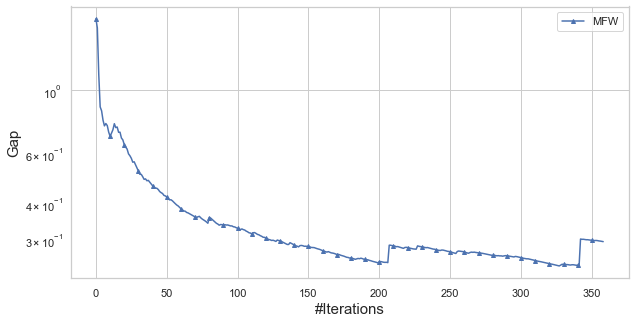

In [65]:
plt.figure(figsize=(10,5))
plt.plot(obj_val[:,0][:-1],obj_val[:,2][:-1], label='MFW', marker='^', markersize=4,
         markevery=[i for i in range(len(obj_val[:,0][1:])) if i%10==0])
#plt.plot(obj_val[:,0][:],average_loss(obj_val[:,2][:]), label='MFW', marker='^', markersize=4,
#         markevery=[i for i in range(len(obj_val[:,0][1:])) if i%10==0])
plt.axhline(y=0, color='grey', linestyle='--')
plt.legend(loc='upper right')
#plt.ylim((1e-4, 1e0))
plt.yscale("log")
plt.xlabel("#Iterations",fontsize=15)
plt.ylabel("Gap",fontsize=15)

Text(0, 0.5, 'Loss')

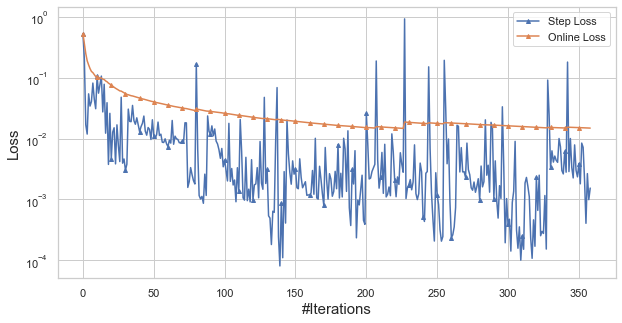

In [66]:
plt.figure(figsize=(10,5))
plt.plot(obj_val[:,0][:-1],obj_val[:,1][:-1], label='Step Loss', marker='^', markersize=4,
         markevery=[i for i in range(len(obj_val[:,0][1:])) if i%10==0])
plt.plot(obj_val[:,0][:-1],average_loss(obj_val[:,1][:-1]), label='Online Loss', marker='^', markersize=4,
         markevery=[i for i in range(len(obj_val[:,0][1:])) if i%10==0])
plt.axhline(y=0, color='grey', linestyle='--')
plt.legend(loc='upper right')
#plt.ylim((1e-3, 1e2))
plt.yscale("log")
plt.xlabel("#Iterations",fontsize=15)
plt.ylabel("Loss",fontsize=15)

In [67]:
def ModelPrediction(model_to_test, date ,loader, lookahead):
    prediction = []
    true = []
    for val, valpred in loader[date]:
        model_to_test.eval()
        pred = model_to_test(val)
        #print(pred.shape)
        prediction.append(pred.detach().numpy())
        true.append(valpred.detach().numpy())
    pred_array = np.asarray(prediction)
    true_array = np.asarray(true)
    #print(pred_array.shape)
    pred_shape = pred_array.shape
    #print(pred_shape)
    flattenTrue = true_array.reshape(pred_shape[0]*pred_shape[1], lookahead)[::lookahead].flatten()
    flattenPred = pred_array.reshape(pred_shape[0]*pred_shape[1], lookahead)[::lookahead].flatten()
    return flattenTrue, flattenPred

In [68]:
def PredictionMultipleDate(model, dates, date_begin, date_end, loader, lookahead, scalers, zone_name):
    predictTrue = []
    predictPred = []
    valuePD = pd.DataFrame()
    idx_begin = dates.index(date_begin)
    idx_end = dates.index(date_end)
    for date in dates[idx_begin:idx_end]:
        true, pred = ModelPrediction(model, date, loader, lookahead)
        maxi = scalers[zone_name].data_max_
        mini = scalers[zone_name].data_min_
        data_range = 1
        #true = ((true.reshape(-1,1) - 0.)*(maxi-mini))/data_range + mini
        #pred = ((pred.reshape(-1,1) - 0.)*(maxi-mini))/data_range + mini
        true = scalers[zone_name].inverse_transform(true.reshape(-1,1))
        pred = scalers[zone_name].inverse_transform(pred.reshape(-1,1))
        array = np.concatenate([true, pred],axis=1)
        result = pd.DataFrame({"Truth": true.squeeze(),
                              "Prediction" : pred.squeeze()})
                              #"Date": pd.date_range(start=date,periods=true.shape[0], freq="5min")})
        valuePD = pd.concat((valuePD, result)).reset_index(drop=True)
    return valuePD

In [69]:
def plotprediction(pandas): 
    plt.figure(figsize=(15,5))
    plt.title(f'{myfloor[indexroom]}')
    plt.plot(pandas["Truth"],label="Truth")
    plt.plot(pandas["Prediction"],label="Prediction",ls='-')
    plt.xticks(ticks=np.arange(pandas.shape[0],step=100))
    plt.legend()
    plt.xlabel("Timestep")
    plt.ylabel(f'{feature}')
    plt.show()

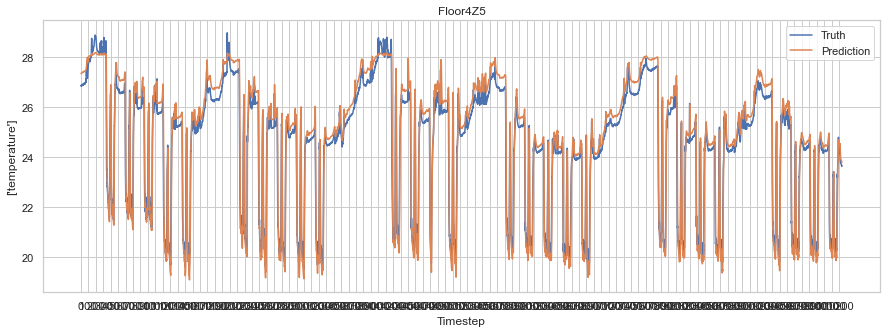

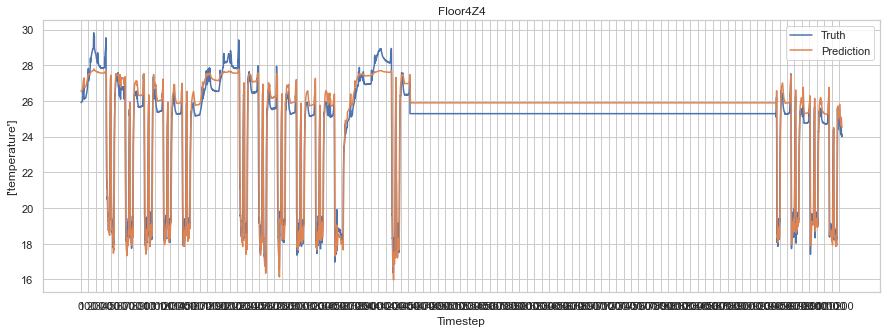

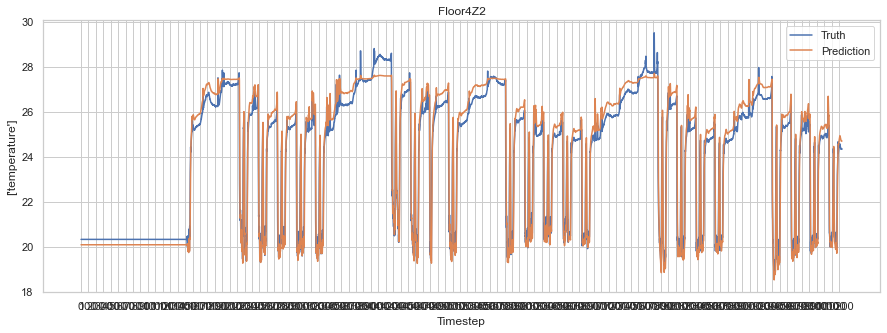

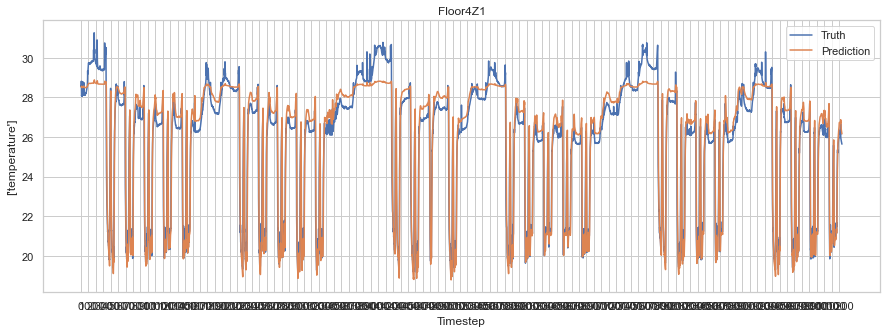

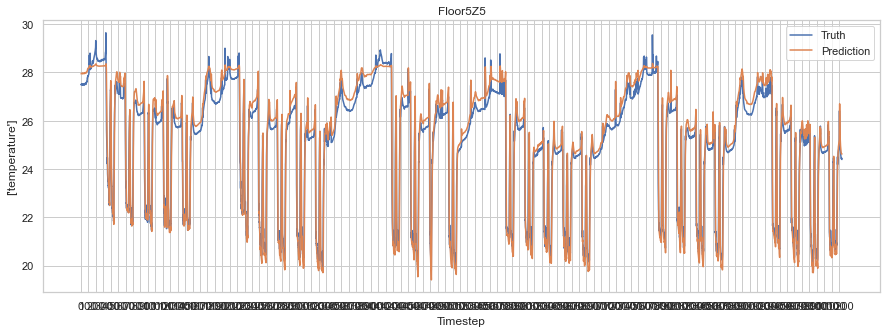

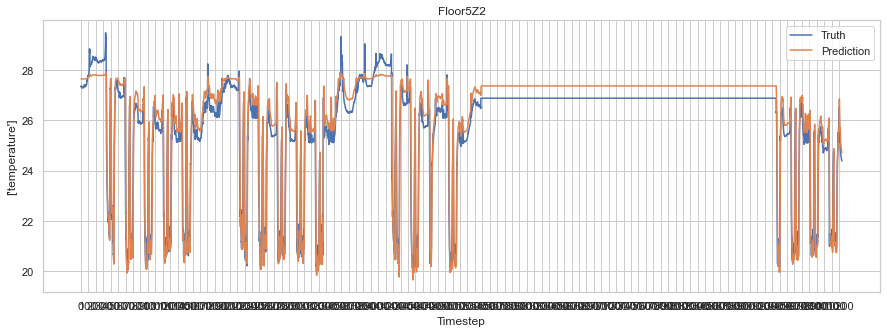

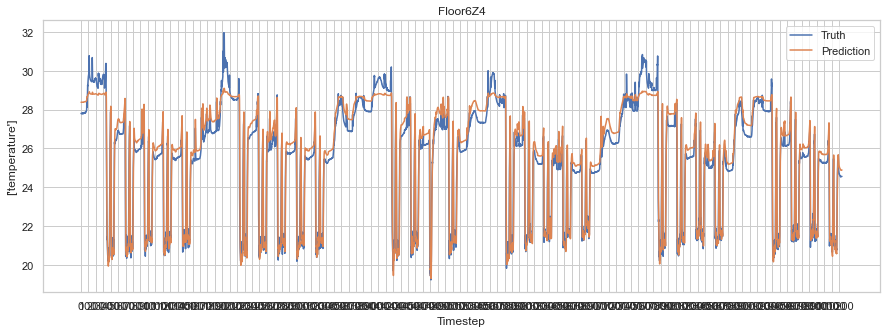

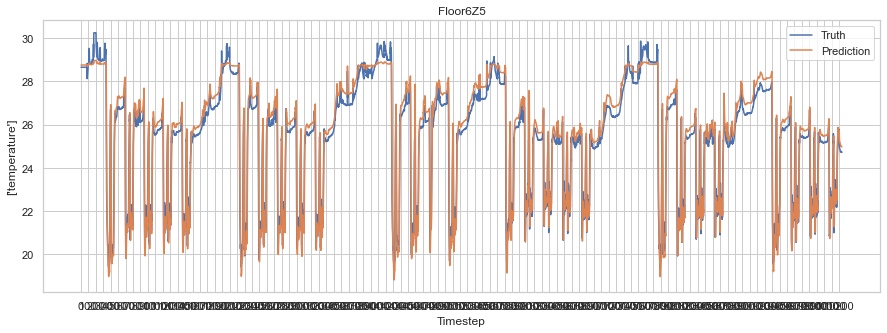

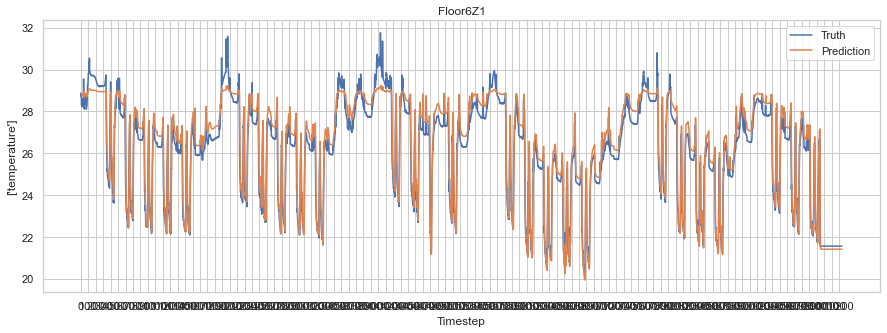

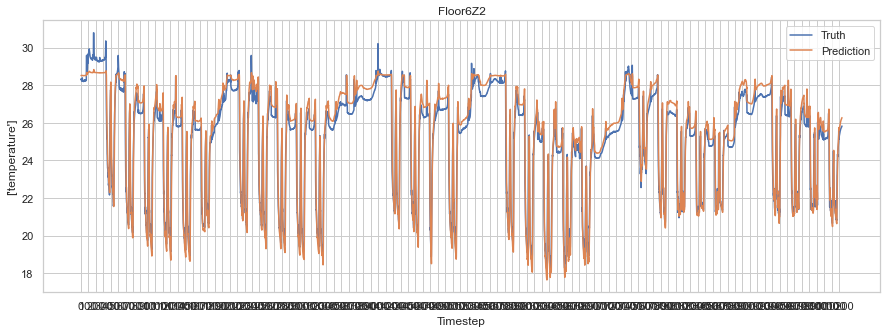

In [70]:
myfloor = zone_id#sorted(list(scaled_data.keys()))
may = [date for date in test_date if '2019-05' in date or "2019-04" in date]
for indexroom in range(len(trainloader)):
    mymodel = trainer.model_algo
    resultpd = PredictionMultipleDate(mymodel,test_date,may[0], may[-1],testloader[indexroom], lookahead, scalers,
                                     myfloor[indexroom])
    plotprediction(resultpd)
    pd.DataFrame.to_csv(resultpd,path_log+f'/prediction-{myfloor[indexroom]}.csv')